In [6]:
# ruff: noqa: T201, T203
from __future__ import annotations

import os
from pathlib import Path

if Path.cwd().name == "notebooks":
    os.chdir("..")

import logging

import pandas as pd
from dotenv import load_dotenv

from config.config import DATA_DIR, RUN_DIR
from config.runs_vars import SUBSET_TO_DATASET_MAP
from src.evaluate import (
    analyze_results,
    get_predictions_with_gt,
    plot_usage_histograms,
    read_run_metrics_df,
    store_run_metrics_df,
)
from src.formatting import (
    format_oracle_pairs_filepath,
    format_run_path,
    format_storing_pathes_from_run_path,
)
from src.LLM_servers.openai import OpenAIServer
from src.onto_access import OntologyAccess
from src.onto_object import OntologyEntryAttr
from src.processing import parallel_samples_process
from src.prompts.system import BASELINE_INITIALIZATION_MESSAGE
from src.utils import read_oracle_pairs, save_run_results

logging.getLogger().setLevel(logging.WARNING)
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
llm_oracle = OpenAIServer(
    api_key=os.environ["GEMINI_API_KEY"], base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)
llm_oracle.add_system_context(BASELINE_INITIALIZATION_MESSAGE)

In [ ]:
DATASET_NAME = "anatomy" # "bioml-2024", "largebio"
SET_NAME = "human-mouse" # "ncit-doid" # "omim-ordo" # "snomed-nci" # "snomed-fma" # "nci-fma"

SOURCE_ONTOLOGY, TARGET_ONTOLOGY = SET_NAME.split("-")

src_onto_path = DATA_DIR / DATASET_NAME / SET_NAME / f"{SOURCE_ONTOLOGY}.owl"
tgt_onto_path = DATA_DIR / DATASET_NAME / SET_NAME / f"{TARGET_ONTOLOGY}.owl"

# src_onto_path = DATA_DIR / DATASET_NAME / SET_NAME / f"oaei_{SOURCE_ONTOLOGY.upper()}_small_overlapping_{TARGET_ONTOLOGY}.owl"  # noqa: E501

onto_src = OntologyAccess(src_onto_path, annotate_on_init=True)
onto_tgt = OntologyAccess(tgt_onto_path, annotate_on_init=True)

* Owlready2 * Creating new ontology doid <data/bioml-2024/ncit-doid/doid.owl#>.
* Owlready2 * ADD TRIPLE data/bioml-2024/ncit-doid/doid.owl http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Ontology
* Owlready2 *     ...loading ontology doid from data/bioml-2024/ncit-doid/doid.owl...


* Owlready2 * Reseting property ann.use_in_alignment: new triples are now available.


* Owlready2 *     ...49 properties found: complicated_by, composed_of, derives_from, has_material_basis_in, has_symptom, inheres_in, is_a, located_in, occurs_with, part_of, realized_by, realized_by_supression_with, results_in, results_in_formation_of, transmitted_by, comment, label, deprecated, use_in_alignment, hasExactSynonym, hasRelatedSynonym, hasOBONamespace, IAO_0000115, IAO_0000231, IAO_0100001, DO_AGR_slim, SubsetProperty, DO_FlyBase_slim, DO_MGI_slim, DO_cancer_slim, DO_rare_slim, GOLD, NCIthesaurus, TopNodes_DOcancerslim, gram-negative_bacterial_infectious_disease, gram-positive_bacterial_infectious_disease, sexually_transmitted_infectious_disease, tick-borne_infectious_disease, zoonotic_infectious_disease, created_by, creation_date, date, default-namespace, hasAlternativeId, hasNarrowSynonym, hasOBOFormatVersion, id, inSubset, saved-by


### Utils Functions


In [9]:
def select_best_direct_entity_names(
    src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr
) -> list[OntologyEntryAttr, OntologyEntryAttr]:
    """If there are multiple direct parents, select one and find child element for it."""
    src_parents = next(iter(src_entity.get_direct_parents()))
    tgt_parents = next(iter(tgt_entity.get_direct_parents()))
    return [x.get_preffered_names() if x else None for x in [src_parents, tgt_parents, src_entity, tgt_entity]]


def format_hierarchy(hierarchy_dict: dict[int, set[OntologyEntryAttr]], no_level: bool = False) -> str:
    formatted = []
    for level, parents in sorted(hierarchy_dict.items()):
        parent_name = next(iter(next(iter(parents)).get_all_entity_names()))
        if no_level:
            formatted.append(parent_name)
        else:
            formatted.append(f"\tLevel {level}: {parent_name}")

    if no_level:
        return formatted
    return "\n".join(formatted)

### Prompt templates


In [10]:
def prompt_direct_entity(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> str:
    """Regular prompt that uses natural language and is more intuitive."""
    src_parent, tgt_parent, src_entity_names, tgt_entity_names = select_best_direct_entity_names(src_entity, tgt_entity)
    return f"""We have two entities from different biomedical ontologies.
The first one is "{src_entity_names}", which falls under the category "{src_parent}".
The second one is "{tgt_entity_names}", which falls under the category "{tgt_parent}".

Do they mean the same thing? Respond with "True" or "False".
"""


def prompt_direct_entity_ontological(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> str:
    """Ontological prompt that uses ontology-focused language."""
    src_parent, tgt_parent, src_entity_names, tgt_entity_names = select_best_direct_entity_names(src_entity, tgt_entity)
    return f"""Analyze the following entities, each originating from a distinct biomedical ontology.
Your task is to assess whether they represent the **same ontological concept**, considering both their semantic meaning and hierarchical position.

1. Source entity: "{src_entity_names}"
\t- Direct ontological parent: "{src_parent}"

2. Target entity: "{tgt_entity_names}"
\t- Direct ontological parent: "{tgt_parent}"

Are these entities **ontologically equivalent** within their respective ontologies? Respond with "True" or "False".
"""  # noqa: E501


def prompt_sequential_hierarchy(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> str:
    """Regular prompt that uses natural language and is more intuitive."""
    src_hierarchy = format_hierarchy(src_entity.get_parents_by_levels(max_level=3), True)
    tgt_hierarchy = format_hierarchy(tgt_entity.get_parents_by_levels(max_level=3), True)

    return "\n".join(
        [
            "We have two entities from different biomedical ontologies.",
            (
                f'The first one is "{src_entity.get_preffered_names()}"'
                + (f', which belongs to the broader category "{src_hierarchy[0]}"' if len(src_hierarchy) >= 1 else "")
                + (f', under the even broader category "{src_hierarchy[1]}"' if len(src_hierarchy) >= 2 else "")
            ),
            (
                f'The second one is "{tgt_entity.get_preffered_names()}"'
                + (f', which belongs to the broader category "{tgt_hierarchy[0]}"' if len(tgt_hierarchy) >= 1 else "")
                + (f', under the even broader category "{tgt_hierarchy[1]}"' if len(tgt_hierarchy) >= 2 else "")
            ),
            'Do they mean the same thing? Respond with "True" or "False".',
        ]
    )


def prompt_sequential_hierarchy_ontological(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> str:
    """Ontological prompt that uses ontology-focused language, and takes hierarchical relationships into account."""
    src_hierarchy = format_hierarchy(src_entity.get_parents_by_levels(max_level=3))
    tgt_hierarchy = format_hierarchy(tgt_entity.get_parents_by_levels(max_level=3))

    return f"""The following entities come from distinct biomedical ontologies.
Each is represented by its **ontological lineage**, capturing its hierarchical placement from the most general to the most specific level.

1. Source entity ontological lineage:
{src_hierarchy}

2. Target entity ontological lineage:
{tgt_hierarchy}

Based on their **ontological positioning, hierarchical relationships, and semantic alignment**, do these entities represent the **same ontological concept**? Respond with "True" or "False".
"""  # noqa: E501


### Test synonyms prompting


In [11]:
TGT_DELIMITER = (
    "/" if DATASET_NAME == "bioml-2024" else "#"
)  # for bioml only because src we need to split by # and tgt by /


def select_best_direct_entity_names_with_synonyms(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> list:
    """Select the best direct entity names and retrieve synonyms for entities and their parents."""
    src_parents = next(iter(src_entity.get_direct_parents()), None)
    tgt_parents = next(iter(tgt_entity.get_direct_parents()), None)

    src_parent_name = src_parents.get_preffered_names() if src_parents else None
    tgt_parent_name = tgt_parents.get_preffered_names() if tgt_parents else None

    src_entity_name = src_entity.get_preffered_names()
    tgt_entity_name = tgt_entity.get_preffered_names()

    src_synonyms = list(src_entity.get_synonyms()) or []
    tgt_synonyms = list(tgt_entity.get_synonyms()) or []

    src_entity_class = src_entity.annotation["uri"].rsplit("#", 1)[-1]
    tgt_entity_class = tgt_entity.annotation["uri"].rsplit(TGT_DELIMITER, 1)[-1]

    # Remove synonyms that are just the entity class name
    if len(src_synonyms) == 1 and src_synonyms[0] == src_entity_class:
        src_synonyms = []
    if len(tgt_synonyms) == 1 and tgt_synonyms[0] == tgt_entity_class:
        tgt_synonyms = []

    return [src_parent_name, tgt_parent_name, src_entity_name, tgt_entity_name, src_synonyms, tgt_synonyms]


def select_best_sequential_hierarchy_with_synonyms(src_parents_by_levels: dict, tgt_parents_by_levels: dict) -> list:
    """Select the best synonyms for an entity and its hierarchical parents."""

    def get_first_synonyms(parent_set: set) -> list:
        """Safely retrieves synonyms from the first available parent entity in the set."""
        if not parent_set:
            return []
        parent = next(iter(parent_set))
        return parent.get_synonyms() if hasattr(parent, "get_synonyms") else []

    src_synonyms = get_first_synonyms(src_parents_by_levels[0])
    src_entity_class = next(iter(src_parents_by_levels[0])).annotation["uri"].rsplit("#", 1)[-1]

    src_parent1_synonyms = get_first_synonyms(src_parents_by_levels[1]) if len(src_parents_by_levels) > 1 else []
    src_parent1_class = (
        next(iter(src_parents_by_levels[1])).annotation["uri"].rsplit("#", 1)[-1]
        if len(src_parents_by_levels) > 1
        else []
    )

    src_parent2_synonyms = get_first_synonyms(src_parents_by_levels[2]) if len(src_parents_by_levels) > 2 else []
    src_parent2_class = (
        next(iter(src_parents_by_levels[2])).annotation["uri"].rsplit("#", 1)[-1]
        if len(src_parents_by_levels) > 2
        else []
    )

    src_parent3_synonyms = get_first_synonyms(src_parents_by_levels[3]) if len(src_parents_by_levels) > 3 else []
    src_parent3_class = (
        next(iter(src_parents_by_levels[3])).annotation["uri"].rsplit("#", 1)[-1]
        if len(src_parents_by_levels) > 3
        else []
    )

    tgt_synonyms = get_first_synonyms(tgt_parents_by_levels[0])
    tgt_entity_class = next(iter(tgt_parents_by_levels[0])).annotation["uri"].rsplit(TGT_DELIMITER, 1)[-1]

    tgt_parent1_synonyms = get_first_synonyms(tgt_parents_by_levels[1]) if len(tgt_parents_by_levels) > 1 else []
    tgt_parent1_class = (
        next(iter(tgt_parents_by_levels[1])).annotation["uri"].rsplit(TGT_DELIMITER, 1)[-1]
        if len(tgt_parents_by_levels) > 1
        else []
    )

    tgt_parent2_synonyms = get_first_synonyms(tgt_parents_by_levels[2]) if len(tgt_parents_by_levels) > 2 else []
    tgt_parent2_class = (
        next(iter(tgt_parents_by_levels[2])).annotation["uri"].rsplit(TGT_DELIMITER, 1)[-1]
        if len(tgt_parents_by_levels) > 2
        else []
    )

    tgt_parent3_synonyms = get_first_synonyms(tgt_parents_by_levels[3]) if len(tgt_parents_by_levels) > 3 else []
    tgt_parent3_class = (
        next(iter(tgt_parents_by_levels[3])).annotation["uri"].rsplit(TGT_DELIMITER, 1)[-1]
        if len(tgt_parents_by_levels) > 3
        else []
    )

    def clean_synonyms(synonyms: set, synonym_class: set) -> list:
        return [] if len(synonyms) == 1 and next(iter(synonyms)) == synonym_class else synonyms

    src_synonyms = clean_synonyms(src_synonyms, src_entity_class)
    src_parent1_synonyms = clean_synonyms(src_parent1_synonyms, src_parent1_class)
    src_parent2_synonyms = clean_synonyms(src_parent2_synonyms, src_parent2_class)
    src_parent3_synonyms = clean_synonyms(src_parent3_synonyms, src_parent3_class)

    tgt_synonyms = clean_synonyms(tgt_synonyms, tgt_entity_class)
    tgt_parent1_synonyms = clean_synonyms(tgt_parent1_synonyms, tgt_parent1_class)
    tgt_parent2_synonyms = clean_synonyms(tgt_parent2_synonyms, tgt_parent2_class)
    tgt_parent3_synonyms = clean_synonyms(tgt_parent3_synonyms, tgt_parent3_class)

    return [
        src_synonyms,
        src_parent1_synonyms,
        src_parent2_synonyms,
        src_parent3_synonyms,
        tgt_synonyms,
        tgt_parent1_synonyms,
        tgt_parent2_synonyms,
        tgt_parent3_synonyms,
    ]

In [12]:
def prompt_direct_entity_with_synonyms(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> str:
    """Natural language prompt that includes synonyms for a more intuitive comparison."""
    src_parent, tgt_parent, src_entity_names, tgt_entity_names, src_synonyms, tgt_synonyms = (
        select_best_direct_entity_names_with_synonyms(src_entity, tgt_entity)
    )

    src_synonyms_text = f", also known as {', '.join(src_synonyms)}" if src_synonyms else ""
    tgt_synonyms_text = f", also known as {', '.join(tgt_synonyms)}" if tgt_synonyms else ""

    return f"""We have two entities from different biomedical ontologies.
The first one is "{src_entity_names}"{src_synonyms_text}, which falls under the category "{src_parent}".
The second one is "{tgt_entity_names}"{tgt_synonyms_text}, which falls under the category "{tgt_parent}".

Do they refer to the same concept? Respond with "True" or "False".
"""


def prompt_sequential_hierarchy_with_synonyms(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> str:
    """Generate a natural language prompt including synonyms and hierarchical relationships."""
    src_parents_by_levels = src_entity.get_parents_by_levels(max_level=3)
    tgt_parents_by_levels = tgt_entity.get_parents_by_levels(max_level=3)
    (
        src_synonyms,
        src_parent1_synonyms,
        src_parent2_synonyms,
        src_parent3_synonyms,
        tgt_synonyms,
        tgt_parent1_synonyms,
        tgt_parent2_synonyms,
        tgt_parent3_synonyms,
    ) = select_best_sequential_hierarchy_with_synonyms(src_parents_by_levels, tgt_parents_by_levels)

    src_hierarchy = format_hierarchy(src_parents_by_levels, True)
    tgt_hierarchy = format_hierarchy(tgt_parents_by_levels, True)

    src_entity_name = f'"{src_hierarchy[0]}"'
    if src_synonyms:
        src_entity_name += f""", also known as {", ".join(f'"{syn}"' for syn in src_synonyms)}"""

    tgt_entity_name = f'"{tgt_hierarchy[0]}"'
    if tgt_synonyms:
        tgt_entity_name += f""", also known as {", ".join(f'"{syn}"' for syn in tgt_synonyms)}"""

    src_hierarchy_text = ""
    if len(src_hierarchy) >= 2:
        src_hierarchy_text += f', which belongs to the broader category "{src_hierarchy[1]}"'
        if src_parent1_synonyms:
            src_hierarchy_text += f""" (also known as {", ".join(f'"{syn}"' for syn in src_parent1_synonyms)})"""
    if len(src_hierarchy) >= 3:
        src_hierarchy_text += f', under the even broader category "{src_hierarchy[2]}"'
        if src_parent2_synonyms:
            src_hierarchy_text += f""" (also known as {", ".join(f'"{syn}"' for syn in src_parent2_synonyms)})"""
    if len(src_hierarchy) >= 4:
        src_hierarchy_text += f', under the even broader category "{src_hierarchy[3]}"'
        if src_parent3_synonyms:
            src_hierarchy_text += f""" (also known as {", ".join(f'"{syn}"' for syn in src_parent3_synonyms)})"""

    tgt_hierarchy_text = ""
    if len(tgt_hierarchy) >= 2:
        tgt_hierarchy_text += f', which belongs to the broader category "{tgt_hierarchy[1]}"'
        if tgt_parent1_synonyms:
            tgt_hierarchy_text += f""" (also known as {", ".join(f'"{syn}"' for syn in tgt_parent1_synonyms)})"""
    if len(tgt_hierarchy) >= 3:
        tgt_hierarchy_text += f', under the even broader category "{tgt_hierarchy[2]}"'
        if tgt_parent2_synonyms:
            tgt_hierarchy_text += f""" (also known as {", ".join(f'"{syn}"' for syn in tgt_parent2_synonyms)})"""
    if len(tgt_hierarchy) >= 4:
        tgt_hierarchy_text += f', under the even broader category "{tgt_hierarchy[3]}"'
        if tgt_parent3_synonyms:
            tgt_hierarchy_text += f""" (also known as {", ".join(f'"{syn}"' for syn in tgt_parent3_synonyms)})"""

    return "\n".join(
        [
            "We have two entities from different biomedical ontologies.",
            f"The first one is {src_entity_name}{src_hierarchy_text}.",
            f"The second one is {tgt_entity_name}{tgt_hierarchy_text}.",
            'Do they mean the same thing? Respond with "True" or "False".',
        ]
    )

In [13]:
src_entity, tgt_entity = read_oracle_pairs(format_oracle_pairs_filepath(DATASET_NAME, SET_NAME))[5]
try:
    src_entity, tgt_entity = OntologyEntryAttr(src_entity, onto_src), OntologyEntryAttr(tgt_entity, onto_tgt)
except AssertionError:
    src_entity, tgt_entity = OntologyEntryAttr(tgt_entity, onto_src), OntologyEntryAttr(src_entity, onto_tgt)

In [14]:
print(prompt_direct_entity_with_synonyms(src_entity, tgt_entity))

We have two entities from different biomedical ontologies.
The first one is "{'Hypogammaglobulinemia'}", which falls under the category "{'Deficiency of Humoral Immunity'}".
The second one is "{'congenital hypogammaglobulinemia'}", which falls under the category "{'B cell deficiency'}".

Do they refer to the same concept? Respond with "True" or "False".



In [15]:
print(prompt_sequential_hierarchy_with_synonyms(src_entity, tgt_entity))

We have two entities from different biomedical ontologies.
The first one is "Hypogammaglobulinemia", which belongs to the broader category "Deficiency of Humoral Immunity", under the even broader category "Immunodeficiency Syndrome", under the even broader category "Syndrome".
The second one is "disease_ontology", which belongs to the broader category "immunoglobulin heavy chain deletion" (also known as "immunoglobulin heavy chain deletion", "B cell (antibody) deficiencies"), under the even broader category "primary immunodeficiency disease", under the even broader category "disease_ontology".
Do they mean the same thing? Respond with "True" or "False".


In [16]:
EXP_NAMES_TO_PROMPT_FUNCTIONS = {
    prompt_function.__name__.replace("prompt_", ""): prompt_function
    for prompt_function in [
        prompt_direct_entity,
        prompt_direct_entity_ontological,
        prompt_sequential_hierarchy,
        prompt_sequential_hierarchy_ontological,
        prompt_direct_entity_with_synonyms,
        prompt_sequential_hierarchy_with_synonyms,
    ]
}

src_entity, tgt_entity = read_oracle_pairs(format_oracle_pairs_filepath(DATASET_NAME, SET_NAME))[0]
try:
    src_entity, tgt_entity = OntologyEntryAttr(src_entity, onto_src), OntologyEntryAttr(tgt_entity, onto_tgt)
except AssertionError:
    src_entity, tgt_entity = OntologyEntryAttr(tgt_entity, onto_src), OntologyEntryAttr(src_entity, onto_tgt)

print(src_entity)
print(tgt_entity)

for name, prompt_function in EXP_NAMES_TO_PROMPT_FUNCTIONS.items():
    print(f"Prompt function: {name}")
    print(prompt_function(src_entity, tgt_entity))
    print("=" * 50)

{'class': ncit.C3252, 'uri': 'http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#C3252', 'preffered_names': {'Benign Granular Cell Tumor'}, 'synonyms': {'C3252'}, 'all_names': {'Benign Granular Cell Tumor'}, 'parents': {owl.Thing}, 'children': set()}
{'class': obo.DOID_5039, 'uri': 'http://purl.obolibrary.org/obo/DOID_5039', 'preffered_names': {'myoblastoma'}, 'synonyms': {'DOID_5039'}, 'all_names': {'disease_ontology', 'myoblastoma'}, 'parents': {obo.DOID_0060072, obo.DOID_461, obo.DOID_0060085, obo.DOID_4, obo.DOID_7, obo.DOID_0060099, obo.DOID_17, owl.Thing, obo.DOID_14566}, 'children': set()}
Prompt function: direct_entity
We have two entities from different biomedical ontologies.
The first one is "{'Benign Granular Cell Tumor'}", which falls under the category "{'Thing'}".
The second one is "{'myoblastoma'}", which falls under the category "{'muscle benign neoplasm'}".

Do they mean the same thing? Respond with "True" or "False".

Prompt function: direct_entity_ontological
Analyze

### Run experiments


Processing Lines prompt_direct_entity: 100%|██████████| 1248/1248 [10:53<00:00,  1.91it/s]


Mean input tockens: 110.9
Mean output tockens: 9.0
Total input tockens: 138420
Total output tockens: 11223


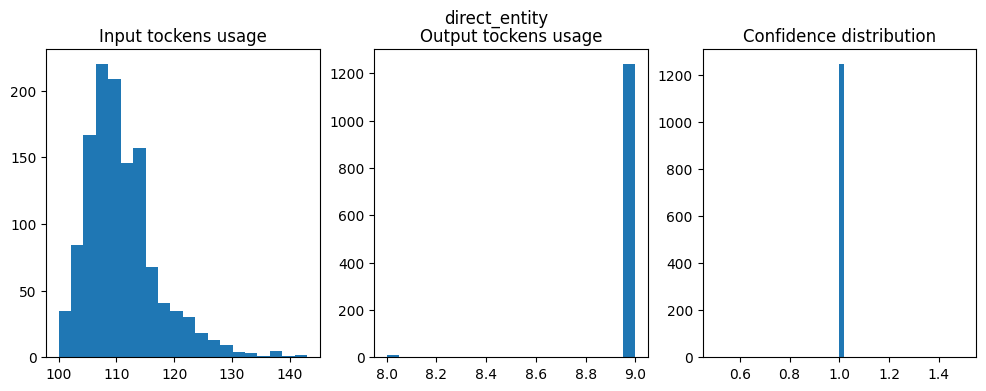

Accuracy: 0.714
Precision: 0.688
Recall: 0.913
F1 Score: 0.784


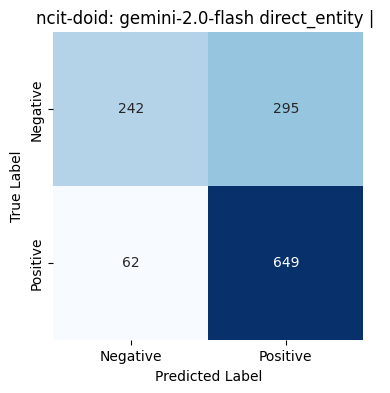

Processing Lines prompt_direct_entity_ontological: 100%|██████████| 1248/1248 [10:53<00:00,  1.91it/s]


Mean input tockens: 153.9
Mean output tockens: 9.0
Total input tockens: 192030
Total output tockens: 11232


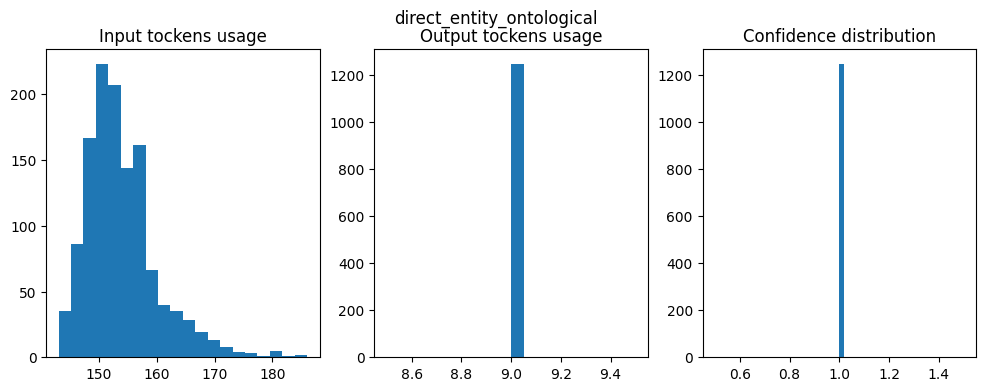

Accuracy: 0.699
Precision: 0.691
Recall: 0.854
F1 Score: 0.764


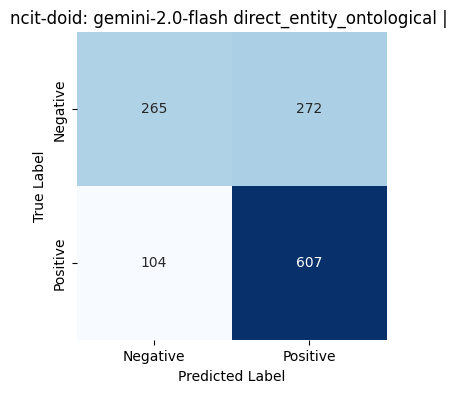

Processing Lines prompt_sequential_hierarchy: 100%|██████████| 1248/1248 [12:19<00:00,  1.69it/s]


Mean input tockens: 132.4
Mean output tockens: 9.0
Total input tockens: 165211
Total output tockens: 11232


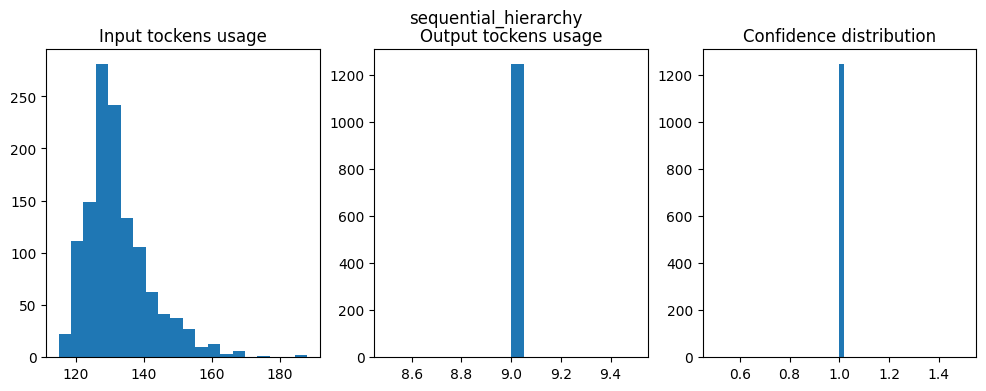

Accuracy: 0.692
Precision: 0.659
Recall: 0.952
F1 Score: 0.779


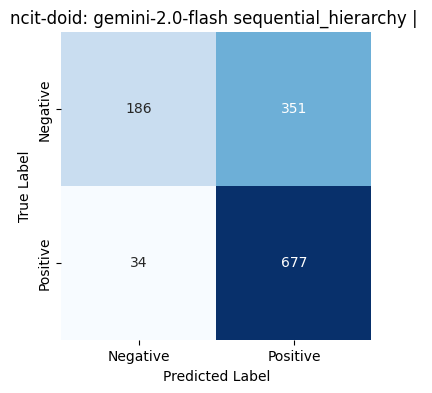

Processing Lines prompt_sequential_hierarchy_ontological: 100%|██████████| 1248/1248 [12:15<00:00,  1.70it/s]


Mean input tockens: 188.5
Mean output tockens: 9.0
Total input tockens: 235197
Total output tockens: 11232


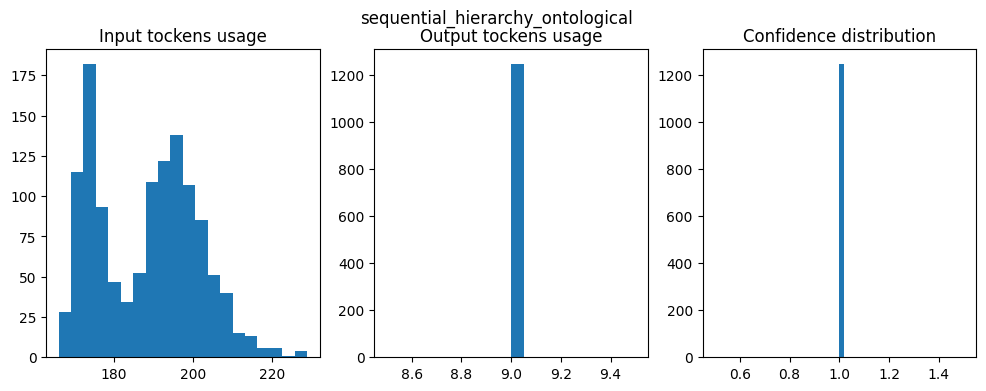

Accuracy: 0.498
Precision: 0.619
Recall: 0.308
F1 Score: 0.411


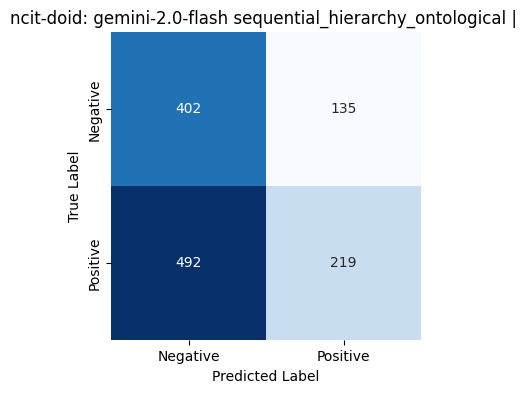

Processing Lines prompt_direct_entity_with_synonyms: 100%|██████████| 1248/1248 [10:55<00:00,  1.90it/s]


Mean input tockens: 122.1
Mean output tockens: 9.0
Total input tockens: 152405
Total output tockens: 11221


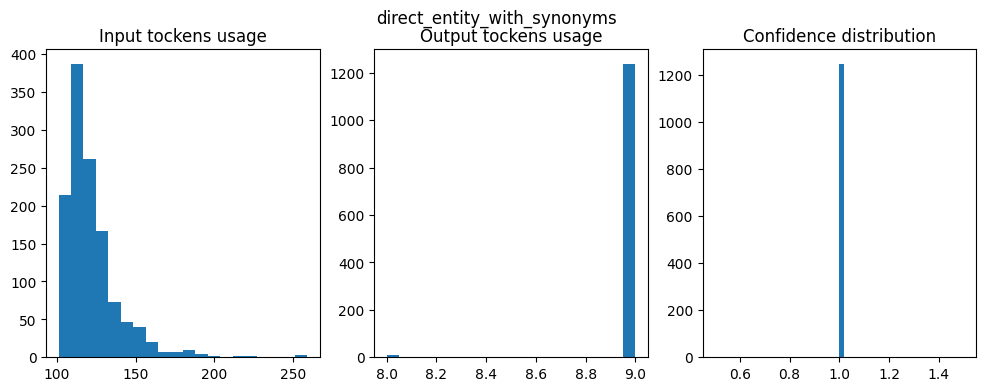

Accuracy: 0.689
Precision: 0.659
Recall: 0.942
F1 Score: 0.775


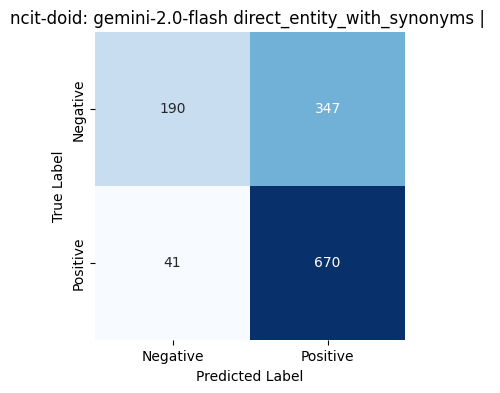

Processing Lines prompt_sequential_hierarchy_with_synonyms: 100%|██████████| 1248/1248 [12:27<00:00,  1.67it/s]


Mean input tockens: 163.4
Mean output tockens: 9.0
Total input tockens: 203939
Total output tockens: 11232


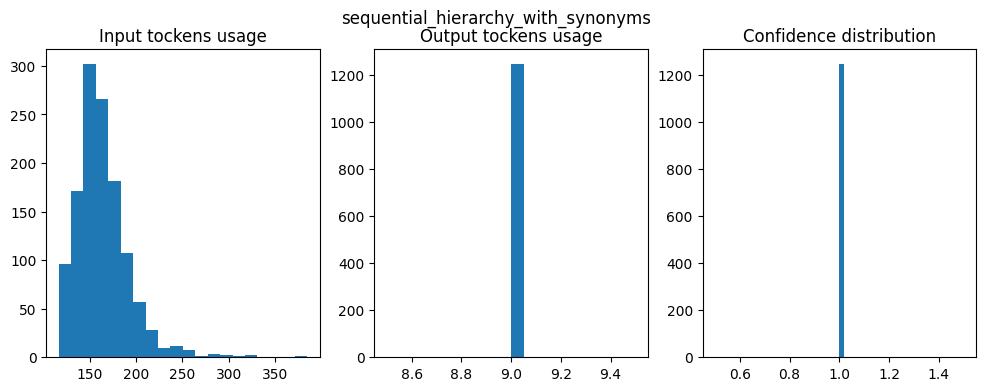

Accuracy: 0.556
Precision: 0.618
Recall: 0.578
F1 Score: 0.597


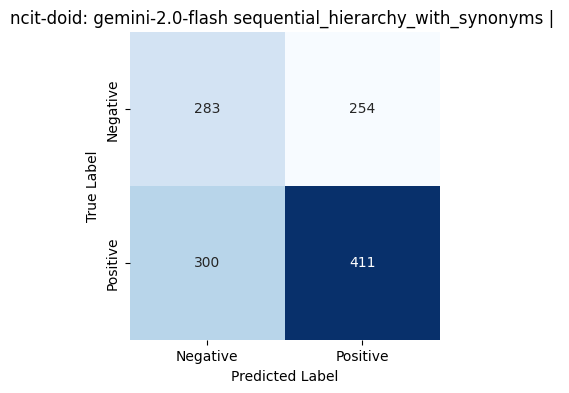

,Experiment,Accuracy,Precision,Recall,F1 Score,Dataset,SubSet,Model
0,direct_entity,0.7139,0.6875,0.9128,0.7843,bioml-2024,ncit-doid,gemini-2.0-flash
1,direct_entity_ontological,0.6987,0.6906,0.8537,0.7635,bioml-2024,ncit-doid,gemini-2.0-flash
2,sequential_hierarchy,0.6915,0.6586,0.9522,0.7786,bioml-2024,ncit-doid,gemini-2.0-flash
3,sequential_hierarchy_ontological,0.4976,0.6186,0.3080,0.4113,bioml-2024,ncit-doid,gemini-2.0-flash
4,direct_entity_with_synonyms,0.6891,0.6588,0.9423,0.7755,bioml-2024,ncit-doid,gemini-2.0-flash
5,sequential_hierarchy_with_synonyms,0.5561,0.6180,0.5781,0.5974,bioml-2024,ncit-doid,gemini-2.0-flash


In [18]:
MAX_WORKERS = 25
MODEL = "gemini-2.0-flash"  # "gpt-4o-mini"

oracle_candidate_pairs_path = format_oracle_pairs_filepath(DATASET_NAME, SET_NAME)

if MODEL.startswith("gemini"):
    llm_oracle = OpenAIServer(
        api_key=os.environ["GEMINI_API_KEY"], base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
    )
else:
    llm_oracle = OpenAIServer(api_key=os.environ["OPENAI_API_KEY"])
llm_oracle.add_system_context(BASELINE_INITIALIZATION_MESSAGE)

oracle_candidate_pairs = read_oracle_pairs(oracle_candidate_pairs_path)[:]

run_path = format_run_path()

for current_exp_name, prompt_function in EXP_NAMES_TO_PROMPT_FUNCTIONS.items():
    results, tokens_usage, confidences = parallel_samples_process(
        oracle_candidate_pairs, llm_oracle, onto_src, onto_tgt, MODEL, MAX_WORKERS, prompt_function
    )
    prediction_path, stats_path, diagram_path = format_storing_pathes_from_run_path(
        run_path, SET_NAME, MODEL, current_exp_name
    )
    save_run_results(results, prediction_path, columns=["Source", "Target", "Prediction", "Confidence"])

    plot_usage_histograms(tokens_usage, confidences, do_plot=True, do_print=True, suptitle=current_exp_name)

    try:
        predictions = get_predictions_with_gt(run_path, DATASET_NAME, SET_NAME, MODEL, current_exp_name)
        analyze_results(
            predictions,
            print_results=True,
            plot_confusion_matrix=True,
            subtitle=f"{SET_NAME}: {MODEL} {current_exp_name} | ",
            cm_save_path=diagram_path,
            stats_path=stats_path,
        )
    except Exception as e:  # noqa: BLE001
        print(f"Error: {e}")

    print("\n")

store_run_metrics_df(EXP_NAMES_TO_PROMPT_FUNCTIONS, run_path, DATASET_NAME, SET_NAME, MODEL)

## Analysis


In [19]:
runs_array = []

for directory in sorted(RUN_DIR.iterdir(), key=lambda x: x.name, reverse=True):
    if not directory.is_dir():
        continue
    for file in directory.iterdir():
        if '_' not in file.name:
            continue
        subset_name, model_name = file.name.split('_')[:2]
        dataset_name = SUBSET_TO_DATASET_MAP.get(subset_name)
    runs_array.append((directory.name, model_name, subset_name, dataset_name))

runs_array

[('2025-04-10_22-11-36', 'gemini-2.0-flash', 'ncit-doid', 'bioml-2024'),
 ('2025-04-10_00-33-19', 'gemini-2.0-flash-lite', 'ncit-doid', 'bioml-2024'),
 ('2025-04-06_22-05-02', 'gemini-2.0-flash-lite', 'omim-ordo', 'bioml-2024'),
 ('2025-04-06_19-27-41', 'gemini-2.0-flash', 'omim-ordo', 'bioml-2024'),
 ('2025-04-06_14-51-00', 'gemini-2.0-flash-lite', 'fma-nci', 'largebio'),
 ('2025-04-06_14-18-46', 'gemini-2.0-flash', 'fma-nci', 'largebio'),
 ('2025-04-04_19-41-28', 'gemini-2.0-flash', 'human-mouse', 'anatomy'),
 ('2025-04-04_19-23-47', 'gemini-2.0-flash-lite', 'human-mouse', 'anatomy'),
 ('2025-04-04_00-43-16', 'gemini-2.0-flash', 'fma-snomed', 'largebio'),
 ('2025-03-28_10-15-04', 'gpt-4o-mini', 'fma-nci', 'largebio'),
 ('2025-03-19_23-32-20', 'gpt-4o-mini', 'omim-ordo', 'bioml-2024'),
 ('2025-03-19_22-17-52', 'gpt-4o-mini', 'ncit-doid', 'bioml-2024'),
 ('2025-03-19_19-48-41', 'gpt-4o-mini', 'human-mouse', 'anatomy'),
 ('2025-03-14_00-40-55', 'gpt-4o-mini', 'ncit-doid', 'bioml-2024'),

In [24]:
runs = [
    ('2025-04-10_22-11-36', 'gemini-2.0-flash', 'ncit-doid', 'bioml-2024'),
    ("2025-04-10_00-33-19", "gemini-2.0-flash-lite", "ncit-doid", "bioml-2024"),
    ("2025-04-06_22-05-02", "gemini-2.0-flash-lite", "omim-ordo", "bioml-2024"),
    ("2025-04-06_19-27-41", "gemini-2.0-flash", "omim-ordo", "bioml-2024"),
    ("2025-04-06_14-51-00", "gemini-2.0-flash-lite", "fma-nci", "largebio"),
    ("2025-04-06_14-18-46", "gemini-2.0-flash", "fma-nci", "largebio"),
    ("2025-04-04_19-41-28", "gemini-2.0-flash", "human-mouse", "anatomy"),
    ("2025-04-04_19-23-47", "gemini-2.0-flash-lite", "human-mouse", "anatomy"),
    ("2025-04-04_00-43-16", "gemini-2.0-flash", "fma-snomed", "largebio"),
    ("2025-03-28_10-15-04", "gpt-4o-mini", "fma-nci", "largebio"),
    ("2025-03-19_23-32-20", "gpt-4o-mini", "omim-ordo", "bioml-2024"),
    ("2025-03-19_22-17-52", "gpt-4o-mini", "ncit-doid", "bioml-2024"),
    ("2025-03-19_19-48-41", "gpt-4o-mini", "human-mouse", "anatomy"),
    ("2025-03-14_00-40-55", "gpt-4o-mini", "ncit-doid", "bioml-2024"),
    ("2025-03-12_17-21-53", "gpt-4o-mini", "human-mouse", "anatomy"),
    ("2025-03-12_14-43-32", "gpt-4o-mini", "omim-ordo", "bioml-2024"),
]

dfs = []

for run_subdir, model, set_name, dataset in runs:
    metrics_df = read_run_metrics_df(run_subdir)
    for col, value in zip(["Dataset", "SubSet", "Model"], [dataset, set_name, model]):
        if col not in metrics_df.columns:
            metrics_df[col] = value
    metrics_df["Run"] = run_subdir
    dfs.append(metrics_df)

results_df = pd.concat(dfs, ignore_index=True)
results_df = results_df.sort_values(by=["Dataset", "SubSet", "Model", "Experiment"])
pd.set_option("display.max_rows", None)

results_df

,Experiment,Accuracy,Precision,Recall,F1 Score,Dataset,SubSet,Model,Run
36,direct_entity,0.8392,0.8476,0.9521,0.8968,anatomy,human-mouse,gemini-2.0-flash,2025-04-04_19-41-28
37,direct_entity_ontological,0.8266,0.8495,0.9281,0.8871,anatomy,human-mouse,gemini-2.0-flash,2025-04-04_19-41-28
40,direct_entity_with_synonyms,0.8492,0.8392,0.9829,0.9054,anatomy,human-mouse,gemini-2.0-flash,2025-04-04_19-41-28
38,sequential_hierarchy,0.8442,0.8423,0.9692,0.9013,anatomy,human-mouse,gemini-2.0-flash,2025-04-04_19-41-28
39,sequential_hierarchy_ontological,0.7990,0.8354,0.9041,0.8684,anatomy,human-mouse,gemini-2.0-flash,2025-04-04_19-41-28
41,sequential_hierarchy_with_synonyms,0.8518,0.8416,0.9829,0.9068,anatomy,human-mouse,gemini-2.0-flash,2025-04-04_19-41-28
42,direct_entity,0.8090,0.9000,0.8322,0.8648,anatomy,human-mouse,gemini-2.0-flash-lite,2025-04-04_19-23-47
43,direct_entity_ontological,0.7186,0.8947,0.6986,0.7846,anatomy,human-mouse,gemini-2.0-flash-lite,2025-04-04_19-23-47
46,direct_entity_with_synonyms,0.8141,0.8283,0.9418,0.8814,anatomy,human-mouse,gemini-2.0-flash-lite,2025-04-04_19-23-47
44,sequential_hierarchy,0.8266,0.8495,0.9281,0.8871,anatomy,human-mouse,gemini-2.0-flash-lite,2025-04-04_19-23-47


In [25]:
results_df.to_csv(RUN_DIR / "all_runs_metrics.csv", index=False)